In [1]:
from keras.layers import Dense, Dropout, Input, ReLU
from keras.models import Model, Sequential
from keras.optimizers import Adam
from keras.datasets import mnist
import numpy as np
import matplotlib.pyplot as plt

In [3]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = (x_train.astype(np.float32)-127.5) / 127.5

print(x_train.shape)

(60000, 28, 28)


In [5]:
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1]*x_train.shape[2])
print(x_train.shape)

(60000, 784)


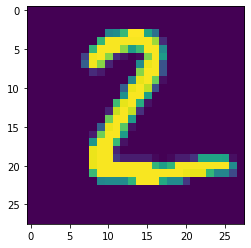

In [7]:
plt.imshow(x_test[1])

In [8]:
def create_generator():
    generator = Sequential()
    generator.add(Dense(units = 512, input_dim = 100))
    generator.add(ReLU())
    
    generator.add(Dense(units = 512))
    generator.add(ReLU())
    
    generator.add(Dense(units = 1024))
    generator.add(ReLU())
    
    generator.add(Dense(units = 784, activation ="tanh"))
    
    generator.compile(loss = "binary_crossentropy",
                      optimizer = Adam(lr = 0.0001, beta_1 = 0.5))
    return generator

g = create_generator()
g.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               51712     
_________________________________________________________________
re_lu (ReLU)                 (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               262656    
_________________________________________________________________
re_lu_1 (ReLU)               (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1024)              525312    
_________________________________________________________________
re_lu_2 (ReLU)               (None, 1024)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 784)               8

In [13]:
def create_discriminator():
    discriminator = Sequential()
    discriminator.add(Dense(units=1024, input_dim = 784))
    discriminator.add(ReLU())
    discriminator.add(Dropout(0.4))
    
    discriminator.add(Dense(units=512))
    discriminator.add(ReLU())
    discriminator.add(Dropout(0.4))
    
    discriminator.add(Dense(units=256))
    discriminator.add(ReLU())
    
    discriminator.add(Dense(units=1, activation="sigmoid"))
    
    discriminator.compile(loss="binary_crossentropy",
                          optimizer=Adam(lr = 0.0001, beta_1=0.5))
    return discriminator

d=create_discriminator()
d.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 1024)              803840    
_________________________________________________________________
re_lu_6 (ReLU)               (None, 1024)              0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_9 (Dense)              (None, 512)               524800    
_________________________________________________________________
re_lu_7 (ReLU)               (None, 512)               0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 256)              

In [15]:
def create_gan(discriminator, generator):
    discriminator.trainable = False
    gan_input = Input(shape=(100, ))
    x = generator(gan_input)
    gan_output = discriminator(x)
    gan = Model(inputs = gan_input, outputs = gan_output)
    gan.compile(loss = "binary_crossentropy", optimizer = "adam")
    return gan

gan = create_gan(d, g)
gan.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
sequential (Sequential)      (None, 784)               1643280   
_________________________________________________________________
sequential_2 (Sequential)    (None, 1)                 1460225   
Total params: 3,103,505
Trainable params: 1,643,280
Non-trainable params: 1,460,225
_________________________________________________________________


In [18]:
epochs = 50
batch_size = 256

for e in range(epochs):
    for _ in range(batch_size):
        noise = np.random.normal(0, 1, [batch_size, 100])
        generated_images = g.predict(noise)
        image_batch = x_train[np.random.randint(low = 0,
                                                high = x_train.shape[0],
                                                size = batch_size)]
        x = np.concatenate([image_batch, generated_images])
        y_dis = np.zeros(batch_size*2)
        y_dis[:batch_size] = 1
        
        d.trainable = True
        d.train_on_batch(x, y_dis)
        
        noise = np.random.normal(0, 1, [batch_size, 100])
        y_gen = np.ones(batch_size)
        
        d.trainable = False
        gan.train_on_batch(noise, y_gen)
    print("epoch: ",e)

epoch:  0
epoch:  1
epoch:  2
epoch:  3
epoch:  4
epoch:  5
epoch:  6
epoch:  7
epoch:  8
epoch:  9
epoch:  10
epoch:  11
epoch:  12
epoch:  13
epoch:  14
epoch:  15
epoch:  16
epoch:  17
epoch:  18
epoch:  19
epoch:  20
epoch:  21
epoch:  22


KeyboardInterrupt: 

In [ ]:
g.save_weights("gans_model.h5")

In [ ]:
noise = np.random.normal(loc = 0, scale = 1, size = [100, 100])
generated_images = g.predict(noise)
generated_images = generated_images.reshape(100, 28, 28)
plt.imshow(generated_images[66], interpolation="nearest")
plt.axis("off")
plt.show()